<a href="https://colab.research.google.com/github/davidislip/RedBlueSetCovering/blob/main/Stochastic_RBSC_Scenarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Red Blue Set Covering 

This notebook focuses on the scenario fomulation of the stochastic RBSC problem. The advantage of the scenario formulation is that there are no assumptions regarding the particular structure of the uncertainty. Specifically, the scenario approach allows for detailed modelling of the random color dependence structure between elements. 

Let $\xi \in \Xi$ represent a scenario out of the possible scenarios. Then 

In [1]:
!sudo python -m pip install gurobipy==9.1.2
!pip install netgraph
import gurobipy as gp
import pandas as pd
import numpy as np
from gurobipy import GRB
from google.colab import drive 
from itertools import product
import math, sys, time
from netgraph import Graph, InteractiveGraph, EditableGraph
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')
pth = 'gdrive/My Drive/Colab Notebooks/'
sys.path.append(pth + 'RBSC/')
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#read in licence info
gurobi_licence = pd.read_csv(pth +'RBSC/gurobi.csv')
print("Required info for Gurobi:", gurobi_licence.columns)
try:
  #web license try to access it via uoft
  e = gp.Env(empty=True)
  #e.setParam('OutputFlag', 0)
  e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
  e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
  e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
  e.start()
except: 
  !chmod 755 /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey
  !/content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey {gurobi_licence.LOCAL[0]}
  e = gp.Env(empty=True)
  #chmod 755 grbgetkey
  e.start()

Required info for Gurobi: Index(['WLSACCESSID', 'LICENSEID', 'WLSSECRET', 'LOCAL'], dtype='object')
Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
info  : grbgetkey version 9.1.2, build v9.1.1rc0-30-g8af970cb
info  : Contacting Gurobi license server...
info  : License file for license ID 782118 was successfully retrieved
info  : License expires at the end of the day on 2022-05-19
info  : Saving license file...

In which directory would you like to store the Gurobi license file?
[hit Enter to store it in /opt/gurobi]: 

A license file already exists in '/opt/gurobi/gurobi.lic'
Continue? [Y/n] 

info  : License 782118 written to file /opt/gurobi/gurobi.lic
Academic license - for non-commercial use only - expires 2022-05-19
Using license file /opt/gurobi/gurobi.lic


In [65]:
import networkx as nx
import random
from rbsc import *

N = 30 #number of sets 
rho = 10 #number of reds
beta = rho #number of blue 
maxBlueProb = 0.1
TransmissionProb = 0.5
Scenarios = 10
CoverFactor = 1
l = 2 #scaling factor for plots 
lambd = 10*(rho+beta)/np.log(1+N) #average elements in set?
Sets = {}

#random scenario generation
#define each element to be a part of a 
#graph. With edge probability p 


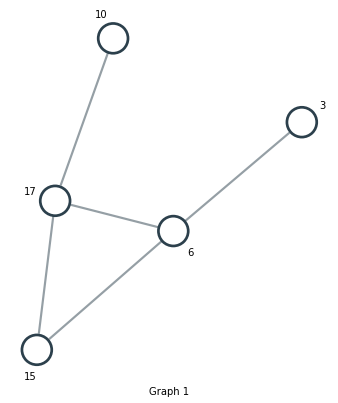

In [66]:
n=rho+beta
n=np.arange(n)+1
# Adapated from https://stackoverflow.com/questions/71024509/create-different-disconnected-graphs-from-a-set-of-fixed-nodes-in-networkx
#randomly permuting nodes
Elements=np.random.permutation(n)

N_graphs= (rho+beta)//20
N_nodes=5
#assign the random modes to each graph
random_graphs_nodes=[Elements[N_nodes*i:N_nodes*(i+1)] for i in range(N_graphs)]

#create random graphs
r_g=[nx.erdos_renyi_graph(n=N_nodes,p=0.5) for _ in range(N_graphs)]

#relabel the nodes in each graph according to random_graphs_nodes
mappings=[]
for i in range(N_graphs):
  mappings.append({j:random_graphs_nodes[i][j] for j in range(N_nodes)})
  r_g[i]=nx.relabel_nodes(r_g[i], mappings[i]) 

#plot result
fig=plt.figure(figsize=(15,6))

for i in range(N_graphs):
  plt.subplot(1,N_graphs,i+1)
  plt.xlabel('Graph '+str(i+1))
  plt.tight_layout()
  # pos=nx.circular_layout(r_g[i])
  # nx.draw(r_g[i],pos=pos,with_labels=True,node_color=colors[i])
  g = Graph(r_g[i],node_labels=True, node_layout = 'spring',
      node_label_fontdict=dict(size=10), node_label_offset=0.05, node_size=3, edge_width=0.4)
  

In [67]:
def propagate(g,b,infectedByb):
  addons = []
  for node in g[b]:
    if np.random.random() <= TransmissionProb:
      infectedByb.append(node)
      new_g = g.copy()
      new_g.remove_node(b)
      propagate(new_g,node,infectedByb)
    else:
      return infectedByb
  return infectedByb


NodeProbability = {e:np.random.random()*maxBlueProb for e in Elements}
RedScenarios = {}
BlueScenarios = {}
for xi in range(Scenarios):
  Blues_xi = {}
  Reds_xi = {}
  for e in Elements:
    if np.random.random() <= NodeProbability[e]:
      Blues_xi[e] = 'B'
  if Blues_xi == {}:
    Blues_xi[e] = 'B'
  InitialBlues= list(Blues_xi.keys())
  for b in InitialBlues:
    for i in range(N_graphs):
      if b in r_g[i].nodes():
        #propagate the fraud
        infectedByb = []
        propagate(r_g[i],b,infectedByb)
        for infected in infectedByb:
          Blues_xi[infected] = 'B'
  Reds_xi = {e:'R' for e in Elements if e not in Blues_xi.keys()}
  BlueScenarios[xi] = Blues_xi
  RedScenarios[xi] = Reds_xi

In [68]:
for xi in BlueScenarios.keys():#test 
  if set(BlueScenarios[xi]).union(set(RedScenarios[xi])) != set(Elements):
    print("Something is wrong")

In [69]:
#form the extensive problem 
ExtensiveBlues = {(b, xi):'B' for xi in BlueScenarios.keys() for b in BlueScenarios[xi].keys()}
#blues are all combinations of xi and blue elements 
#reds are all combinations of xi and red elements + one red for each x, blue pair with weight lambda 
#sets are the given sets plus the super sets for each xi, blue element pair
ExtensiveReds = {(r, xi): 'R' for xi in RedScenarios.keys() for r in RedScenarios[xi].keys()}
ExtensiveRedsWeights = {(r, xi): 1/Scenarios for xi in RedScenarios.keys() for r in RedScenarios[xi].keys()}

BlueMapping = {}
LastElement = max(Elements)
k = 1
for (b, xi) in ExtensiveBlues.keys():
  BlueMapping[(b, xi)] = (LastElement + k, xi)
  ExtensiveReds[(LastElement + k, xi)] = 'Super'
  ExtensiveRedsWeights[(LastElement + k, xi)] = lambd/Scenarios
  k = k + 1

In [70]:
#form first stage sets that cover elements that are ever blue
k = 0
EverBlues = set(b for (b,xi) in ExtensiveBlues.keys())
UncoveredBlues = [b for b in EverBlues]
#randomly sample until all the blues are covered 
while (k < N or UncoveredBlues != []):
  n_k = random.sample(range(1,(1+len(Elements))//CoverFactor),1)[0]
  DoesNotCoverAnyBlue = True
  while DoesNotCoverAnyBlue:
    SetCandidate = random.sample(list(Elements), n_k)
    BlueCoveredBool = [b in SetCandidate for b in EverBlues]
    if True in BlueCoveredBool:
      DoesNotCoverAnyBlue = False
  if UncoveredBlues == []:
    ind = 'Set' + str(k)
    Sets[ind] = SetCandidate
    k = k+1

  CoversNewBlue = False
  for element in EverBlues:
    if element in SetCandidate and element in UncoveredBlues:
      UncoveredBlues.remove(element)
      CoversNewBlue = True
  if CoversNewBlue:
    ind = 'Set' + str(k)
    Sets[ind] = SetCandidate
    k = k+1


In [71]:
ExtensiveFormElements = set(product(Elements, range(Scenarios)))
### A test for the extensive form of the elements is below
#ExtensiveFormElements == set(ExtensiveBlues.keys()).union(set(ExtensiveReds.keys()))
#ExtensiveFormElements

In [72]:
BlueScenarios[1]

{1: 'B', 20: 'B'}

In [73]:
ScenarioFormSets = {}
#appending the base elements for each scenario
for S in Sets.keys():
  ScenarioFormSets[S] = []
  for e, xi in ExtensiveFormElements:
    probability_swap = 0.1
    if e in Sets[S] and probability_swap <= np.random.random():
      ScenarioFormSets[S].append((e,xi))
    else:
      RandomSet = random.choice(list(Sets.keys()))
      try:
        ScenarioFormSets[RandomSet].append((e,xi))
      except:
        ScenarioFormSets[RandomSet] = []


#appending the super sets
SuperLookup = {}
bLookup = {}
k = 0
for (b, xi) in ExtensiveBlues:
  (r, xi2) = BlueMapping[(b,xi)]
  ScenarioFormSets['Super'+str(k)] = [(b, xi), (r, xi)]
  RedScenarios[xi][r] = 'R' #include the new red elements here
  SuperLookup[(b, xi)] =  'Super'+str(k)
  bLookup[('Super'+str(k), xi)] = b
  k += 1


In [74]:
ScenarioFormSets.keys()

dict_keys(['Set0', 'Set16', 'Set1', 'Set14', 'Set26', 'Set19', 'Set2', 'Set5', 'Set28', 'Set29', 'Set24', 'Set15', 'Set27', 'Set3', 'Set21', 'Set18', 'Set25', 'Set20', 'Set12', 'Set4', 'Set8', 'Set17', 'Set10', 'Set9', 'Set23', 'Set11', 'Set6', 'Set7', 'Set13', 'Set22', 'Super0', 'Super1', 'Super2', 'Super3', 'Super4', 'Super5', 'Super6', 'Super7', 'Super8', 'Super9', 'Super10', 'Super11', 'Super12', 'Super13'])

In [75]:
SetsIndexedbyScenario = {}
for xi in range(Scenarios):
  SetsinScenario = {}
  for S in ScenarioFormSets.keys():
    Temp = []
    for pair in ScenarioFormSets[S]:
      if pair[1] == xi: 
        Temp.append(pair[0])
    if Temp != []:
      SetsinScenario[S] = Temp
  SetsIndexedbyScenario[xi] = SetsinScenario
SetsinScenario

#getting the weights indexed by scenario
WeightsIndexedbyScenario = {}
for xi in range(Scenarios):
  WeightsinScenario = {}
  for (r, xi_2), wgt in ExtensiveRedsWeights.items():
    if xi_2 == xi:
      WeightsinScenario[r] = wgt
  WeightsIndexedbyScenario[xi] = WeightsinScenario

### The deterministic problem

$$
\begin{equation}
\begin{aligned}
\underset{x,y}{\min}& \sum_{r\in R}  y_r &\\
\text{s.t} \quad y_r &\geq x_S &\forall (r,S): r \in S \cap R \\
\sum_{S \ni b} x_S &\geq 1 &\forall b \in B\\
x_S \in \{0,1\}&,\  y_r \geq 0
\end{aligned}
\end{equation}
$$

and consider the stochastic counterpart with $\lambda$ penalty for missing a blue element in scenario $\xi$

$$
\begin{equation}
\begin{aligned}
\underset{x,y}{\min} & \sum_{\xi \in \Xi} \sum_{r\in R(\xi)} p_{\xi} y_r^{(\xi)}+\sum_{\xi \in \Xi} \sum_{b\in B(\xi)} p_{\xi} \lambda w_b^{(\xi)}& \\
\text{s.t}\  & y_r^{(\xi)} \geq x_S \ \ \ \quad \forall (r,S): r \in S \cap R(\xi) \ \forall \xi \in \Xi & \\
& w_b^{(\xi)} + \sum_{S \ni b}  x_S \geq 1  \quad \forall b \in B(\xi) \  \forall \xi \in \Xi&\\
& x_S \in \{0,1\},\  y_r \geq 0, w_b^{(\xi)} \in \{0,1\}&
\end{aligned}
\end{equation}
$$

The problem above can be equivalently formulated as an instance of the deterministic set covering problem where the blue elements are given by the element-scenario pairs in which the element is blue for the given scenario:
$$
B = \{(b, \xi): b \in B(\xi) \  \xi \in \Xi\}
$$ 

The red elements are given by the element-scenario pairs in which the element is red in the given scenario along with a set of additional elements. Each red element-scenario pair has a weight given by $p_{\xi}$.
$$
R' = \{(r, \xi): r \in R(\xi) \  \xi \in \Xi \}
$$ 
Additional red elements called super elements are given by adding one red element for each blue element - scenario pair denoted by $(r_{b}, \xi)$ with weight $\lambda p_{\xi}$. 

$$
R'' = \{(r_{b}, \xi): b \in B(\xi) \  \xi \in \Xi \}
$$ 

The super elements represent the ability to pay $\lambda p_{\xi}$ to cover the blue elements. 
Lasty, the collection of sets is augmented as follows: each of the original sets $S$ which contains the same set of elements for every scenario is mapped to it's corresponding set of element scenario pairs:
$$
S' = \{(e, \xi):\xi \in \Xi \ e \in S\}
$$
along with the new 'super sets' that contain the super elements and thier corresponding blue elements:
$$
S'' = \{(b, \xi), (r_b,  \xi) :b \in B(\xi)\  \xi \in \Xi \}
$$
The new collection of sets if given by $\mathcal{S}' \cup \mathcal{S}''$.

In this notation, the following optimization problem is equivalent to the stochastic variant:

$$
\begin{equation}
\begin{aligned}
\underset{x,y}{\min}& \sum_{r\in R' \cup R''}  y_r &\\
\text{s.t} \quad y_r &\geq x_S &\forall (r,S): r \in S \cap R' \cup R'' \\
\sum_{S \ni b} x_S &\geq 1 &\forall b \in B\\
x_S \in \{0,1\}&,\  y_r \geq 0
\end{aligned}
\end{equation}
$$


In [76]:

def DeterministicRedBlueTest(Reds, Blues, Sets, Weights = None):
  '''
  Direct implementation of the deterministic red blue set covering problem
  '''
  
  m = gp.Model()

  x = m.addVars(Sets.keys(), vtype = GRB.BINARY)
  y = m.addVars(Reds.keys(), vtype = GRB.CONTINUOUS, lb = 0)

  if Weights == None:
    m.setObjective(y.sum(), GRB.MINIMIZE)
  else:
    m.setObjective(gp.quicksum(Weights[r]*y[r] for r in Reds.keys()), GRB.MINIMIZE)

  # for r in Reds.keys():
  #   m.addConstrs((y[r] >= x[S] for S in Sets.keys() if r in Sets[S]))

  for S in Sets.keys():
    m.addConstrs((y[r] >= x[S] for r in set(Sets[S]).intersection(set(Reds.keys()))))
  for b in Blues.keys():
    m.addConstr(gp.quicksum(x[S] for S in \
                            {Set for Set in Sets.keys() if b in Sets[Set]})\
                >= 1)
  m.optimize()
  #gety
  SelectedReds = [r for r in y.keys() if y[r].x > 0.5]
  #getx
  SelectedSets = [s for s in x.keys() if x[s].x > 0.5]  

  SolnEdgestoBlue = [(b,S) for S in SelectedSets for b in set(Sets[S]).intersection(set(Blues.keys()))]
  SolnEdgestoRed = [(r,S) for S in SelectedSets for r in set(Sets[S]).intersection(set(Reds.keys()))]
  SolnEdges = SolnEdgestoBlue+SolnEdgestoRed
  return SelectedReds, SelectedSets, SolnEdges, m

In [77]:
SelectedReds, SelectedSets, SolnEdges, m = DeterministicRedBlueTest(ExtensiveReds, ExtensiveBlues, ScenarioFormSets, ExtensiveRedsWeights)
SelectedSets

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 3214 rows, 244 columns and 6663 nonzeros
Model fingerprint: 0x7f33857b
Variable types: 200 continuous, 44 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 15.7000000
Presolve removed 14 rows and 14 columns
Presolve time: 0.04s
Presolved: 3200 rows, 230 columns, 6635 nonzeros
Variable types: 0 continuous, 230 integer (230 binary)

Root relaxation: objective 1.240000e+00, 553 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.32857    0  212   15.70000    1.32857  91.5%     -    0s
     0     0    1.75663    0  213   15.70000    1

['Set6']

In [78]:
m.write("input.lp")
presolved_model = m.presolve()
print(presolved_model.IsQCP)
print(presolved_model.IsQP)
presolved_model.printStats()
presolved_model.write("presolved.lp")

0
0

Statistics for model _pre :
  Linear constraint matrix    : 3200 Constrs, 230 Vars, 6635 NZs
  Variable types              : 0 Continuous, 230 Integer (230 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0.1, 5.82413 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]


In [79]:
print("Selected sets: ", SelectedSets)
print("Extensive blues: ", ExtensiveBlues)
print("Selected Reds: ", SelectedReds)

Selected sets:  ['Set6']
Extensive blues:  {(9, 0): 'B', (20, 1): 'B', (1, 1): 'B', (9, 2): 'B', (20, 3): 'B', (1, 3): 'B', (9, 4): 'B', (20, 5): 'B', (9, 6): 'B', (5, 7): 'B', (10, 8): 'B', (17, 8): 'B', (10, 9): 'B', (17, 9): 'B'}
Selected Reds:  [(10, 0), (6, 0), (3, 0), (17, 0), (15, 0), (12, 0), (20, 0), (19, 0), (4, 0), (1, 0), (8, 0), (5, 0), (7, 0), (18, 0), (10, 1), (3, 1), (17, 1), (15, 1), (11, 1), (2, 1), (8, 1), (5, 1), (7, 1), (18, 1), (9, 1), (10, 2), (3, 2), (17, 2), (11, 2), (12, 2), (20, 2), (19, 2), (1, 2), (2, 2), (5, 2), (7, 2), (10, 3), (3, 3), (17, 3), (4, 3), (5, 3), (7, 3), (16, 3), (18, 3), (9, 3), (10, 4), (3, 4), (17, 4), (15, 4), (12, 4), (20, 4), (19, 4), (4, 4), (1, 4), (13, 4), (8, 4), (5, 4), (7, 4), (14, 4), (10, 5), (3, 5), (17, 5), (15, 5), (1, 5), (13, 5), (5, 5), (7, 5), (16, 5), (18, 5), (9, 5), (10, 6), (3, 6), (17, 6), (11, 6), (20, 6), (19, 6), (4, 6), (1, 6), (13, 6), (2, 6), (8, 6), (5, 6), (7, 6), (10, 7), (3, 7), (17, 7), (12, 7), (20, 7), 

### Convert the problem to one where each set has only one blue element

* In this case the follow constraint is valid for a minimal solution: $y_r \geq \sum_{S \ni {r,b}} x_S \quad \forall (r,b) \in R \times B$ 

* In the case that there are multiple sets covering $b$ then all but one of the sets can be discarded at non excess cost. 

* Another inequality is added to ensure that the approximation algorithm guarantees and $2 \sqrt{n k}$ bound where $ k = \max_{i} |S_i \cap B|$: For $b \in B$, let $\mu_b = \min_{S \ni b} |S \cap R|$ then it follows that: 

$$
\begin{equation}
\sum_{r \in R} y_r \geq \mu_b \quad \forall b \in B
\end{equation}
$$

### Peleg Approximation Algorithm 



In [80]:
#store degree in dict
BestCover, MinWgt = LowDeg2(ExtensiveReds, ExtensiveBlues, ScenarioFormSets, ExtensiveRedsWeights)

In [81]:
BestCover.keys(), MinWgt

(dict_keys(['Set1', 'Set11', 'Set27', 'Set9']), 15.89999999999996)

### Standard Benders decomposition on the augmented version of the problem (stochastic case)

The master problem is:

$$
\begin{aligned}
\min_{\theta \in \mathbb{R}_+, x \in \{0,1\}^{|\mathcal{S}|}} \quad  &\sum_{\xi \in \Xi} \theta^{(\xi)} \\
\text{s.t} \quad & \theta^{(\xi)} \geq Q^{(\xi)}(x) \\
\end{aligned}
$$

where the subproblem $Q^{(\xi)}$  for a given master problem solution $x_S^*$ is given by:
$$
\begin{equation}
\begin{aligned}
&\underset{x, y, z}{\min}  \sum_{r\in R(\xi)} p_{\xi} y_r+\sum_{b\in B(\xi)} p_{\xi} \lambda w_b& \\
\text{s.t}\quad   & y_r \geq x_S \ \ \ \quad &\forall (r,S): r \in S \cap R(\xi) \   \\
& w_b \geq 1 - \sum_{S \ni b}  x_S  \quad &\forall b \in B(\xi) \  &\\
& x_S = x_S^* \quad &\forall S \in \mathcal{S}\\
& \  y_r \geq 0,\  x_S \in \{0,1\}, \   w_b \geq 0 &
\end{aligned}
\end{equation}
$$

dropping the constraint $x_S = x_S^* \forall S \in \mathcal{S}$ implies that the problem above can be expressed as an instance of RBSC where:

* Additional red elements called super elements are added by introducing one red element for each blue element with weight $p_{\xi}\lambda$ denoted by $r_{b}$ for $b \in B(\xi)$ 
* Additional sets are introduced for each blue element; denoted by $S_b$ such that $S_b = \{r_b, b \} \ \forall b \in B(\xi)$

Let $\bar{\mathcal{S}} = \mathcal{S} \cup ⋃_{b \in B(\xi)} S_b$ and $\bar{R} (\xi)= R(\xi) \cup ⋃_{b \in B(\xi)} \{r_b\}$ then the subproblem (excluding the master problem constraint) can be equivalently replaced by the following instance of red blue set covering


$$
\min_{y \in \mathbb{R}^{|\bar{R}(\xi)|}} 
{\big \{ } 
\sum_{r\in \bar{R}(\xi)}c_r y_r\  
| \ y_r \geq x_S \ \forall S \in \bar{\mathcal{S}}: r \in S \cap \bar{R} (\xi), \ y \geq 0, \  x \in \{0,1\}^{|\bar{R} (\xi)|}{\}}
$$

where $c_r$ is equal to $p_{\xi}$ when $r \in R(\xi)$, and  $\lambda p_{\xi}$ when $r \in ⋃_{b \in B(\xi)} \{r_b\}$. Enforcing the constraints that $x_S = x_S^* \ \forall S \in  \mathcal{S}$ implies for $S_{b'} \in \mathcal{\bar{S}} - \mathcal{S} = \bigcup_{b \in B(\xi)} S_b$ that $x_{S_{b'}}$ must be one if $b'$ is not covered by $\{S \subseteq \mathcal{S} : x_S^* = 1 \}$ to satisfy the covering constraint. If $b'$ is covered by $\{S \subseteq \mathcal{S} : x_S^* = 1 \}$ then setting  $x_{S_{b'}} = 0$ is a feasible solution and is optimal because setting $x_{S_{b'}} = 1$ would only increase the cost of the cover. 

The dual of the RBSC instance above $Q^{(\xi)}$ takes the following form:

$$
\max_{\pi} {\big \{ } \sum_{S \in \mathcal{\bar{S}}} \sum_{r\in S} x_S \pi_{rS} \  
| \ \sum_{S \ni r} \pi_{rS} \leq c_r \ \forall r \in \bar{R} (\xi),
\  \pi \geq 0 {\}}
$$

Cuts are generated by solving the dual subproblem and checking for violations of the contraint $\theta^{(\xi)} \geq Q^{(\xi)}(x)$ which corresponds to a cut of the form:
$$
\theta^{(\xi)} \geq \sum_{S \in \mathcal{S}} \sum_{r \in S} \pi^*_{rS} x_S + \sum_{S_b \in \bigcup_{b \in B(\xi)}} \sum_{r \in S} \pi^*_{rS} \text{max}(1 - \sum_{S \ni b}x_S, 0)
$$

since $x_{S_b} + \sum_{S \in \mathcal{S} \ni b} x_S \geq 1$ and $x_{S_b} \geq 0$. Which inequality is the maximum violation? If $\sum_{S \ni b} x_S  = 0$ i.e. x_{S_b} = 1 then the RHS is maximized by considering $1 - \sum_{S \ni b}x_S$. Else it is maximized by considering $x_{S_b} = 0$
$$
\theta^{(\xi)} \geq \sum_{S \in \mathcal{S}} \sum_{r \in S} \pi^*_{rS} x_S + \sum_{S_b \in \bigcup_{b \in B(\xi)}} \sum_{r \in S} \pi^*_{rS} x^*_{S_b}(1 - \sum_{S \ni b}x_S)
$$


<!-- \text{max}( 1 - \sum_{S \ni b} x_{S}, 0) -->



In [82]:
### Primal subproblem implementation
xi = 0

vals_x = {S: 0 for S in SetsIndexedbyScenario[xi].keys()}
for S in BestCover.keys():
  vals_x[S] = 1

m_sub = gp.Model()
y = m_sub.addVars(RedScenarios[xi].keys(), obj = WeightsIndexedbyScenario[xi], name='y', lb = 0, vtype = GRB.CONTINUOUS)

for S in SetsIndexedbyScenario[xi].keys():
  m_sub.addConstrs((y[r] >= vals_x[S] for r in set(SetsIndexedbyScenario[xi][S]).intersection(set(RedScenarios[xi].keys()))))

m_sub.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 333 rows, 20 columns and 333 nonzeros
Model fingerprint: 0xf6525271
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 333 rows and 20 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds
Optimal objective  1.400000000e+00


In [83]:
def subproblem(xi,SetsIndexedbyScenario, RedScenarios, WeightsIndexedbyScenario, vals_x,  output = False):
  ### dual subproblem implementation 
  m_sub = gp.Model()
  #red element set combinatations where r is in S 
  if output == False:
    m_sub.Params.OutputFlag = 0

  RedSetCombos = {(r,S) for S in SetsIndexedbyScenario[xi].keys() for r in RedScenarios[xi].keys() if r in SetsIndexedbyScenario[xi][S]}
  pi = m_sub.addVars(RedSetCombos, name='pi', lb = 0, vtype = GRB.CONTINUOUS)

  for r in RedScenarios[xi].keys():
    SetsContainingr = {Set for Set in SetsIndexedbyScenario[xi].keys() if r in SetsIndexedbyScenario[xi][Set]}
    if SetsContainingr!= None:
      m_sub.addConstr(gp.quicksum(pi[(r,S)] for S in SetsContainingr) <= WeightsIndexedbyScenario[xi][r])

  m_sub.setObjective(gp.quicksum(vals_x[S]*pi[(r,S)] for (r,S) in pi.keys()), GRB.MAXIMIZE)
  m_sub.optimize()

  vals_pi = {(r,S):pi[(r,S)].x for (r,S) in pi.keys()}
  ObjVal = m_sub.ObjVal
  return vals_pi, ObjVal

vals_pi, ObjVal = subproblem(xi,SetsIndexedbyScenario, RedScenarios, WeightsIndexedbyScenario, vals_x, output = True)
ObjVal

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 20 rows, 333 columns and 333 nonzeros
Model fingerprint: 0x047385d8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 20 rows and 333 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  1.400000000e+00


1.4000000000000001

In [84]:
# Callback - use lazy constraints (and user cuts) to add benders cuts
def benders(model, where):
    if where == GRB.Callback.MIPSOL:    # This is the LAZY CONSTRAINT, called only when an INTEGER solution is found
                                        # (mandatory, you can't find the optimal solution w/o the lazy constraints)
      global counter
      global PrintInfo
      if PrintInfo:
        print('**************************************************')
        print('Integer solution is found...')
      
      vals_x_firststage = model.cbGetSolution(x)
      #theta = [var for var in model.getVars() if 'theta' in var.varName]
      #this causes theta[0] to refer to the variable
      vals_theta = model.cbGetSolution(theta)
      UB = 0
      LB = 0

      for xi in range(Scenarios):
        FirstStageSets = set(SetsIndexedbyScenario[xi].keys()).intersection(BendersSets)
        SuperSetsinScenario = set(SetsIndexedbyScenario[xi].keys()).intersection(SuperSets)

        vals_x = {S: 0 for S in SetsIndexedbyScenario[xi].keys()}
        elementscovered = set()
        for S in vals_x_firststage.keys():
          if S in vals_x.keys():
            vals_x[S] = vals_x_firststage[S]
            if vals_x[S] > 0.9:
              elementscovered = elementscovered.union(set(SetsIndexedbyScenario[xi][S]))
        #get uncovered blue elements 
        uncoveredblues = set(BlueScenarios[xi].keys()) - elementscovered
        if uncoveredblues!= set():
          for b in uncoveredblues:
            vals_x[SuperLookup[(b, xi)]] = 1
        # print(vals_x)
        # print(SuperSetsinScenario)
        #full solution including super sets is in vals_x
        vals_pi, SubVal = subproblem(xi,SetsIndexedbyScenario, RedScenarios, WeightsIndexedbyScenario, vals_x)

        RedSetCombos_1 = {(r,S) for S in FirstStageSets 
                          for r in set(SetsIndexedbyScenario[xi][S]).intersection(set(RedScenarios[xi].keys()))}

        RedSetCombos_2 =  {(r,S) for S in SuperSetsinScenario 
                          for r in set(SetsIndexedbyScenario[xi][S]).intersection(set(RedScenarios[xi].keys()))}
        SetsContainingBlues = {}
        for b in BlueScenarios[xi].keys():
          SetsContainingBlues[b] = set()
          for S in FirstStageSets:
            if b in SetsIndexedbyScenario[xi][S]:
              SetsContainingBlues[b].add(S)
        Triples = {(r,Sb,FirstStageS) for (r,Sb) in RedSetCombos_2 for FirstStageS in SetsContainingBlues[bLookup[(Sb, xi)]]}
        # print(xi)
        # print({S for S in vals_x if vals_x[S] == 1})
        # print({(r,S):vals_pi[(r,S)] for (r,S) in RedSetCombos_2})
        # print(SetsIndexedbyScenario[xi])
        # print(vals_x)
        if PrintInfo:
          print("\n\n\n")
          print("At iteration " + str(counter) + ", ")
        
          #print("x = ", list(vals_x))
          print("Theta val = ", vals_theta[xi])
          print("Master objective value (LB) = ", vals_theta[xi])
          #print("pi = ", list(vals_pi.values()))
          print("Benders cut bound = ", SubVal)
        
        status = SubVal - vals_theta[xi] >= 0.00001
        if PrintInfo:
          print("Is their any violation?", status)
        if status:
            if PrintInfo: 
              print('Benders cut added...')
            model.cbLazy(theta[xi] >= 
                    sum(x[S]*vals_pi[(r,S)] for (r,S) in RedSetCombos_1)
                    +sum(1*vals_pi[(r,S)]*vals_x[S] for (r,S) in RedSetCombos_2)
                    - sum(x[FirstStageS]*vals_pi[(r,Sb)]*vals_x[Sb] for (r,Sb,FirstStageS) in Triples))
        else:
            if PrintInfo:
              print('No violation')
        UB += SubVal
        LB += vals_theta[xi]
        if PrintInfo:
          print("UB - LB = ", UB - LB)
          print("\n\n\n")

          print('**************************************************')
    
      counter += 1


In [85]:
#globals
counter = 0
PrintInfo = False
xWarm = {S:0 for S in ScenarioFormSets.keys()}
for S in BestCover:
  xWarm[S] = 1
BendersSets = set(Sets.keys()) #first stage sets not including the super sets 
SuperSets = set(ScenarioFormSets) - set(BendersSets)

In [86]:
ScenarioFormSets.keys()

dict_keys(['Set0', 'Set16', 'Set1', 'Set14', 'Set26', 'Set19', 'Set2', 'Set5', 'Set28', 'Set29', 'Set24', 'Set15', 'Set27', 'Set3', 'Set21', 'Set18', 'Set25', 'Set20', 'Set12', 'Set4', 'Set8', 'Set17', 'Set10', 'Set9', 'Set23', 'Set11', 'Set6', 'Set7', 'Set13', 'Set22', 'Super0', 'Super1', 'Super2', 'Super3', 'Super4', 'Super5', 'Super6', 'Super7', 'Super8', 'Super9', 'Super10', 'Super11', 'Super12', 'Super13'])

In [87]:
#Bender Set keys is the first stage sets
m = gp.Model()
# Create variables
x = m.addVars(BendersSets, vtype = GRB.BINARY, lb = 0, ub = 1, name = 'x')
theta = m.addVars(Scenarios, obj = 1, name='theta', lb = 0)

#subproblem

for xi in range(Scenarios):
  #full solution including super sets is in vals_x
  vals_x = {S: 0 for S in SetsIndexedbyScenario[xi].keys()}
  elementscovered = set()
  for S in BestCover.keys():
    if S in vals_x.keys():
      vals_x[S] = 1
      elementscovered = elementscovered.union(set(SetsIndexedbyScenario[xi][S]))
  #get uncovered blue elements 
  uncoveredblues = set(BlueScenarios[xi].keys()) - elementscovered
  if uncoveredblues!= set():
    for b in uncoveredblues:
      vals_x[b] = 1
      
  vals_pi, ObjVal = subproblem(xi,SetsIndexedbyScenario, RedScenarios, WeightsIndexedbyScenario, vals_x)
  FirstStageSets = set(SetsIndexedbyScenario[xi].keys()).intersection(BendersSets)
  SuperSetsinScenario = set(SetsIndexedbyScenario[xi].keys()).intersection(SuperSets)

  RedSetCombos_1 = {(r,S) for S in FirstStageSets 
                    for r in set(SetsIndexedbyScenario[xi][S]).intersection(set(RedScenarios[xi].keys()))}

  RedSetCombos_2 =  {(r,S) for S in SuperSetsinScenario 
                     for r in set(SetsIndexedbyScenario[xi][S]).intersection(set(RedScenarios[xi].keys()))}
  #sets that contain the element associated with the super set 
  SetsContainingBlues = {}
  for b in BlueScenarios[xi].keys():
    SetsContainingBlues[b] = set()
    for S in FirstStageSets:
      if b in SetsIndexedbyScenario[xi][S]:
        SetsContainingBlues[b].add(S)
  Triples = {(r,Sb,FirstStageS) for (r,Sb) in RedSetCombos_2 for FirstStageS in SetsContainingBlues[bLookup[(Sb, xi)]]}
  m.addConstr(theta[xi] >= 
                sum(x[S]*vals_pi[(r,S)] for (r,S) in RedSetCombos_1)
                +sum(1*vals_pi[(r,S)]*vals_x[S] for (r,S) in RedSetCombos_2)
                - sum(x[FirstStageS]*vals_pi[(r,Sb)]*vals_x[Sb]  for (r,Sb,FirstStageS) in Triples))


In [88]:
# Optimize model
m._x = x

m.Params.lazyConstraints = 1 # # To be used with lazy constraints
m.optimize(benders)

vals = m.getAttr('x', x)

print('')
print('Optimal x: %s' % str(vals))
print('Optimal cost: %g' % m.objVal)
print('')

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 10 rows, 40 columns and 42 nonzeros
Model fingerprint: 0x06aa2ef0
Variable types: 10 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 10 rows, 40 columns, 42 nonzeros
Variable types: 10 continuous, 30 integer (30 binary)

Root relaxation: objective 0.000000e+00, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.98852    0   27          -    0.98852      -     -    1s
     0     0    1.04264    0   24          -    1.04264      - 

In [89]:
# **************************************************
# 1
# {'Set8', 'Set9', 31}
# {(68, 42): 0.0, (70, 2): 0.0, (69, 29): 0.0, (71, 57): 0.0}

xi = 1
FirstStageSets = set(SetsIndexedbyScenario[xi].keys()).intersection(BendersSets)
SuperSetsinScenario = set(SetsIndexedbyScenario[xi].keys()).intersection(SuperSets)

SuperSetsinScenario
BlueScenarios[xi]
#SetsIndexedbyScenario[xi]

{1: 'B', 20: 'B'}

**A** naive benders implementation does not achieve good results, it takes too long. 

### Dual benders cuts formulation on the augmented problem

For a given solution of the master problem $x^*$. In Benders Dual Decomposition cuts for scenario $\xi \in \Xi$ are derived by solving:

$$\underset{y,z}{\min} {\Big \{} \sum_{r \in \bar{R}(\xi)} c_r y_r \ |\  \sum_{S \ni b} z_S \geq 1\ \forall b \in B(\xi),
\ y_r \geq z_S \ \ \forall S \in \bar{\mathcal{S}}: r \in S \cap \bar{R} (\xi),\  z = x^*,\  y_r \in \mathbb{R}_+,\  \ z_S \in \mathbb{R}_+ {\Big \}}$$ (1)

resulting in the following optimality cut:

$$ \theta \geq \sum_{r \in \bar{R}(\xi)} c_r \bar{y}_r + \sum_{S \in \mathcal{\bar{S}}} \bar{\lambda}_S (x_S - \bar{z}_S)$$ (2)

where $\bar{\lambda}_S$ is the dual multipler associated with the constraint $x_S = z_S$ for set $S$

Rahmaniani et. al. show that pricing the constraints $x = z$ into the objective function and solving the lagarangian dual problem yields stronger cuts. Let $Y$ denote $\{(y,z) \in \mathbb{R}^{|R|\times|\mathcal{S}|} |  \sum_{S \ni b} z_S \geq 1\ \forall b,\ y_r \geq z_S \ \forall (S,r): r \in S \}$. The lagrangian dual problem takes the following form: 

$$\underset{\lambda}{\max} 
\underset{y,z \in X}{\min} {\Big \{} 
\sum_{r \in \bar{R}(\xi)} c_r y_r + \sum_{S \in \mathcal{\bar{S}}} \lambda_S (x^*_S - z_S)\ 
|\  z_S \in \{0,1\} 
{\Big \}}$$(3)

resulting in the following optimality cut:

$$\theta \geq \sum_{r \in \bar{R}(\xi)} c_r \bar{y}_r + \sum_{S \in \mathcal{\bar{S}}} \bar{\lambda}_S (x_S - \bar{z}_S)$$ (4)

which is equivalent to
$$\theta \geq \sum_{r \in \bar{R}(\xi)} c_r \bar{y}_r + \sum_{S \in \mathcal{S}} \bar{\lambda}_S (x_S - \bar{z}_S) + \sum_{b \in \bigcup_{b\in B(\xi)}}\bar{\lambda}_{S_b} (x_{S_b} - \bar{z}_{S_b})$$ (5)
and in terms of the first stage sets $\mathcal{S}$ can be expressed as 
$$\theta \geq \sum_{r \in \bar{R}(\xi)} c_r \bar{y}_r + \sum_{S \in \mathcal{S}} \bar{\lambda}_S (x_S - \bar{z}_S) + \sum_{b \in \bigcup_{b\in B(\xi)}}\bar{\lambda}_{S_b} ( \text{max}(1 - \sum_{S \ni b \subseteq \mathcal{S}}x_S, 0) - \bar{z}_{S_b})$$ (6)
which as per the argument above corresponds to:
$$\theta \geq \sum_{r \in \bar{R}(\xi)} c_r \bar{y}_r + \sum_{S \in \mathcal{S}} \bar{\lambda}_S (x_S - \bar{z}_S) + \sum_{b \in \bigcup_{b\in B(\xi)}}\bar{\lambda}_{S_b} ( x_{S_b}(1 - \sum_{S \ni b \subseteq \mathcal{S}} x_S) - \bar{z}_{S_b})$$ (7)
which expanded 
$$\theta \geq \sum_{r \in \bar{R}(\xi)} c_r \bar{y}_r + \sum_{S \in \mathcal{S}} \bar{\lambda}_S (x_S - \bar{z}_S) 
+ \sum_{b \in \bigcup_{b\in B(\xi)}}\bar{\lambda}_{S_b} (x^*_{S_b}-\bar{z}_{S_b})-
\sum_{b \in \bigcup_{b\in B(\xi)}} \sum_{S \ni b \subseteq \mathcal{S}}\bar{\lambda}_{S_b} x^*_{S_b} x_S
$$ (8)

The lagrangian problem is challenging to solve. To combat this Rahmaniani et. al. use a a phased approach. The phased approach begins by generating the first set of optimality cuts by solving (1) hence generating (2). Then, using the dual values obtained from (1) denoted by $\bar{\lambda}^{(0)}$, the inner minimization in (3) is solved to obtain $\bar{y}^{(0)}, \bar{z}^{(0)}$ and the resulting cut (4) is added. The third phase focuses on heuristically solving the lagrangian dual by lifting the cuts as much as possible. The procedure is as follows: assume that a given series of values (corresponding to cuts) $\bar{y}^{(k)}, \bar{z}^{(k)}, \bar{\lambda}^{(k)}$ $k = 1,2,...,t-1$ has been obtained. The next approximate lagrangian cut is obtained by solving:

$$
\begin{aligned}
\underset{\eta \in \mathbb{R}, \lambda \in \mathbb{R}^{|\mathcal{\bar{S}}|}}{\max} \quad &\eta - \frac{\delta}{2}||\lambda^{(t-1)} - \lambda||_2^2\\
\text{s.t}\quad &\eta \leq \sum_{r \in R} c_r \bar{y}_r^{(k)} + \sum_{S \in \mathcal{\bar{S}}} \lambda_S(x^*_S - \bar{z}^{(k)}) \quad  k = 1,2,...,t-1
\end{aligned}
$$
(9)

to obtain $\bar{\lambda}^{(t)}$. Then, $\bar{\lambda}^{(t)}$ is used to obtain  $\bar{y}^{(t)}, \bar{z}^{(t)}$  by solving the inner minimization of the  lagrangian dual:

$$\bar{y}^{(t)}, \bar{z}^{(t)} =  \underset{y,z \in X}{\text{argmin}} {\Big \{} \sum_{r \in R} y_r + \sum_{S} \bar{\lambda}^{(t)}_S (x^*_S - z_S)\  |\  z_S \in \{0,1\} {\Big \}}$$(10)


In [90]:
### Primal subproblem implementation
xi = 0

vals_x = {S: 0 for S in SetsIndexedbyScenario[xi].keys()}
for S in BestCover.keys():
  vals_x[S] = 1

m_sub = gp.Model()
y = m_sub.addVars(RedScenarios[xi].keys(), obj = WeightsIndexedbyScenario[xi], name='y', lb = 0, vtype = GRB.CONTINUOUS)

for S in SetsIndexedbyScenario[xi].keys():
  m_sub.addConstrs((y[r] >= vals_x[S] for r in set(SetsIndexedbyScenario[xi][S]).intersection(set(RedScenarios[xi].keys()))))

m_sub.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 333 rows, 20 columns and 333 nonzeros
Model fingerprint: 0xf6525271
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 333 rows and 20 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  1.400000000e+00


In [91]:
#subproblem implementation for testing 
xi = 0
vals_x = {S: 0 for S in SetsIndexedbyScenario[xi].keys()}
for S in BestCover.keys():
  vals_x[S] = 1
def subproblemBDDP1(xi,SetsIndexedbyScenario, RedScenarios, BlueScenarios, WeightsIndexedbyScenario, vals_x,  output = False):

  m_sub = gp.Model()
  #red element set combinatations where r is in S 
  if output == False:
    m_sub.Params.OutputFlag = 0
  y = m_sub.addVars(RedScenarios[xi].keys(), obj = WeightsIndexedbyScenario[xi], name='y', lb = 0, vtype = GRB.CONTINUOUS)
  z = m_sub.addVars(SetsIndexedbyScenario[xi].keys(), obj = 0, name='z', lb = 0, vtype = GRB.CONTINUOUS)

  for S in SetsIndexedbyScenario[xi].keys():
    m_sub.addConstrs((y[r] >= z[S] for r in set(SetsIndexedbyScenario[xi][S]).intersection(set(RedScenarios[xi].keys()))) )
  blue_constrs = []
  for b in BlueScenarios[xi].keys():
    c = m_sub.addConstr(gp.quicksum(z[S] for S in \
                            {Set for Set in SetsIndexedbyScenario[xi].keys() if b in SetsIndexedbyScenario[xi][Set]})\
                >= 1)
    blue_constrs.append(c)

  LinkConstraint = m_sub.addConstrs((z[S] == vals_x[S] for S in z.keys()))### does not matter 
  m_sub._LinkConstraint = LinkConstraint #for the call back

  m_sub.optimize()
  # vals_v = None
  # if m_sub.status  == 3:
  #   #infeasible then we have to solve the feasibility problem
  #   v  = m_sub.addVars(BlueScenarios[xi].keys(), name='v', lb = 0, vtype = GRB.CONTINUOUS)
  #   for b in BlueScenarios[xi].keys():
  #     m_sub.remove(blue_constrs)
  #     blue_constrs[b].RHS = 1 - v[b]
  #     m_sub.addConstr(v[b] + gp.quicksum(z[S] for S in \
  #                           {Set for Set in SetsIndexedbyScenario[xi].keys() if b in SetsIndexedbyScenario[xi][Set]})\
  #               >= 1)
  #   m_sub.setObjective(v.sum(), GRB.MINIMIZE)
  #   m_sub.optimize()
  #   vals_v = m_sub.getAttr('x', v)
  vals_y = m_sub.getAttr('x', y)
  vals_z = m_sub.getAttr('x', z)
  Pi = m_sub.getAttr('Pi', m_sub._LinkConstraint)
  BDD1ObjVal = m_sub.ObjVal
  return vals_y, vals_z, Pi, BDD1ObjVal

vals_y, vals_z, Pi, BDD1ObjVal = subproblemBDDP1(xi,SetsIndexedbyScenario, RedScenarios, BlueScenarios, WeightsIndexedbyScenario, vals_x,  output = True)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 365 rows, 51 columns and 717 nonzeros
Model fingerprint: 0x09a0b53e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 365 rows and 51 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  1.400000000e+00


In [92]:
#subproblem for phase 2 
def subproblemBDDP2(xi,SetsIndexedbyScenario, RedScenarios, BlueScenarios, WeightsIndexedbyScenario, vals_x, Pi, J = None, output = False):
  m_lagrangian = gp.Model()
  #red element set combinatations where r is in S 
  if output == False:
    m_lagrangian.Params.OutputFlag = 0
  y_lagrangian = m_lagrangian.addVars(RedScenarios[xi].keys(), 
                                      obj = WeightsIndexedbyScenario[xi], 
                                      name='y', lb = 0, vtype = GRB.CONTINUOUS)
  z_lagrangian = m_lagrangian.addVars(SetsIndexedbyScenario[xi].keys(),
                                      obj = 0, name='z', vtype = GRB.BINARY)
  m_lagrangian.setObjective(
      gp.quicksum(WeightsIndexedbyScenario[xi][r]*y_lagrangian[r] for r in y_lagrangian.keys()) 
      - gp.quicksum(z_lagrangian[S]*Pi[S] for S in SetsIndexedbyScenario[xi].keys()) 
      + gp.quicksum(vals_x[S]*Pi[S] for S in SetsIndexedbyScenario[xi].keys()) )
  
  for S in SetsIndexedbyScenario[xi].keys():
    m_lagrangian.addConstrs((y_lagrangian[r] >= z_lagrangian[S] 
                             for r in set(SetsIndexedbyScenario[xi][S]).intersection(set(RedScenarios[xi].keys()))))

  for b in BlueScenarios[xi].keys():
    m_lagrangian.addConstr(gp.quicksum(z_lagrangian[S] for S in \
                            {Set for Set in SetsIndexedbyScenario[xi].keys() if b in SetsIndexedbyScenario[xi][Set]})\
                >= 1)
  if J != None:
    for S in J:
      z_lagrangian[S].vtype = GRB.CONTINUOUS
      z_lagrangian[S].lb = 0
      z_lagrangian[S].ub = 1
  m_lagrangian.optimize()
  vals_y_lagrang = m_lagrangian.getAttr('x', y_lagrangian)
  vals_z_lagrang = m_lagrangian.getAttr('x', z_lagrangian)
  LagrangianObjVal = m_lagrangian.ObjVal
  return vals_y_lagrang, vals_z_lagrang, LagrangianObjVal

vals_y_lagrang, vals_z_lagrang, LagrangianObjVal = subproblemBDDP2(xi,SetsIndexedbyScenario, RedScenarios, BlueScenarios, WeightsIndexedbyScenario, vals_x, Pi, J = None, output = False)


In [93]:
#heuristic lifting sub problem
m_lifting = gp.Model()
#red element set combinatations where r is in S 
m_lifting.Params.OutputFlag = 0
eta = m_lifting.addVar(name='eta', lb = 0, vtype = GRB.CONTINUOUS)
lambd = m_lifting.addVars(SetsIndexedbyScenario[xi].keys(), name='lambda', vtype = GRB.CONTINUOUS)
m_lifting._lambd = lambd #for easy removal in callback
# m_lifting.remove(m_lifting._lambd)

#### Implementation

In [94]:

# Callback - use lazy constraints (and user cuts) to add benders cuts
def BDD(model, where):
  global counter
  global PrintInfo
  global IntegerX
  global delta
  global epsilon
  global xWarm
  if where == GRB.Callback.MIPSOL:    # This is the LAZY CONSTRAINT, called only when an INTEGER solution is found
                                        # (mandatory, you can't find the optimal solution w/o the lazy constraints)
    if PrintInfo:
      print('**************************************************')
      print('Integer solution is found...')
    #change to warm start here if you'd like
    vals_x_firststage = model.cbGetSolution(x)
    #theta = [var for var in model.getVars() if 'theta' in var.varName]
    #this causes theta[0] to refer to the variable
    vals_theta = model.cbGetSolution(theta)
    UB = 0
    LB = 0
    
    for xi in range(Scenarios):

        FirstStageSets = set(SetsIndexedbyScenario[xi].keys()).intersection(BendersSets)
        SuperSetsinScenario = set(SetsIndexedbyScenario[xi].keys()).intersection(SuperSets)
        #for input into the subproblem
        vals_x = {S: 0 for S in SetsIndexedbyScenario[xi].keys()}
        elementscovered = set()
        for S in vals_x_firststage.keys():
          if S in vals_x.keys():
            vals_x[S] = vals_x_firststage[S]
            if vals_x[S] > 0.9:
              elementscovered = elementscovered.union(set(SetsIndexedbyScenario[xi][S]))
        #get uncovered blue elements 
        uncoveredblues = set(BlueScenarios[xi].keys()) - elementscovered
        if uncoveredblues!= set():
          for b in uncoveredblues:
            vals_x[SuperLookup[(b, xi)]] = 1

                  #add the resulting cut
        SetsContainingBlues = {}
        for b in BlueScenarios[xi].keys():
          SetsContainingBlues[b] = set()
          for S in FirstStageSets:
            if b in SetsIndexedbyScenario[xi][S]:
              SetsContainingBlues[b].add(S)

        # build the subproblem (it's better to build it once, outside the callback, and then modify it inside - left as an exercise)
        vals_y, vals_z, Pi, BDD1ObjVal = subproblemBDDP1(xi,SetsIndexedbyScenario, 
                                                        RedScenarios, BlueScenarios,
                                                        WeightsIndexedbyScenario, 
                                                        vals_x,  output = False)

        if PrintInfo:
          print("\n\n\n")
          print("At iteration " + str(counter) + ", ")
          print("Theta val = ", vals_theta[xi])
          print("Master objective value (LB) = ", vals_theta[xi])
          print("Benders cut bound = ",BDD1ObjVal)
      
        status = BDD1ObjVal - vals_theta[xi] >= 0.001
        if PrintInfo:
          print("Is their any violation?", status)
        if status:
          if PrintInfo: 
            print('Benders cut added...')
            print([vals_z[S]*Pi[S] for S in x.keys()])
            print(vals_z)
            print(vals_x)
            print(Pi)
          # $$\theta \geq 
          # \sum_{r \in \bar{R}(\xi)} c_r \bar{y}_r + 
          # \sum_{S \in \mathcal{S}} \bar{\lambda}_S (x_S - \bar{z}_S) +
          # \sum_{b \in \bigcup_{b\in B(\xi)}}\bar{\lambda}_{S_b} (x^*_{S_b}-\bar{z}_{S_b}) -
          # \sum_{b \in \bigcup_{b\in B(\xi)}} \sum_{S \ni b \subseteq \mathcal{S}}\bar{\lambda}_{S_b} x^*_{S_b} x_S
          # $$ (8)

          BlueElementSetPairs = {(Sb, FirstStageS) for Sb in SuperSetsinScenario for FirstStageS in SetsContainingBlues[bLookup[(Sb, xi)]]}

          model.cbLazy(theta[xi] >= sum(vals_y[r]*WeightsIndexedbyScenario[xi][r] for r in vals_y.keys())
                        + gp.quicksum(x[S]*Pi[S] for S in FirstStageSets)
                        - sum(vals_z[S]*Pi[S] for S in FirstStageSets)
                        + sum(Pi[Sb]*(vals_x[Sb] - vals_z[Sb]) for Sb in SuperSetsinScenario)
                        - gp.quicksum(Pi[Sb]*vals_x[Sb]*x[S] for (Sb, S) in BlueElementSetPairs))
          # else:
          #   model.cbLazy(0 >= vals_v.sum()
          #                 + gp.quicksum(x[S]*Pi[S] for S in FirstStageSets)
          #                 - sum(vals_z[S]*Pi[S] for S in x.keys())
          #                 + sum(Pi[Sb]*(vals_x[Sb] - vals_z[Sb]) for Sb in SuperSetsinScenario)
          #                 - gp.quicksum(Pi[Sb]*vals_x[Sb]*x[S] for (Sb, S) in BlueElementSetPairs))
        else:
          print('No violation')
        #update bounds
        UB += BDD1ObjVal
        LB += vals_theta[xi]
        if PrintInfo:
          print("UB - LB = ", UB - LB)
          print("\n\n\n")
        #if we are at the root node and have added a cut
        if model.cbGet(GRB.Callback.MIPSOL_NODCNT) < 1 and IntegerX and status:
          #begin phase #2 by solving the inner lagragian

          #first change the variable types for the fractional master problem solutions
          #force them to be integer, let all the already integer variables 
          #be relaxed and free
          J = {S for S in vals_x.keys() if vals_x[S] 
                <= math.ceil(vals_x[S]) - epsilon and
                vals_x[S] >= math.floor(vals_x[S]) + epsilon}

          #solve the inner lagrange problem 
          vals_y_lagrang, vals_z_lagrang, LagrangianObjVal = subproblemBDDP2(xi, 
                                                                             SetsIndexedbyScenario, 
                                                                             RedScenarios, 
                                                                             BlueScenarios, 
                                                                             WeightsIndexedbyScenario, 
                                                                             vals_x, 
                                                                             Pi, J)
          #phase 2 solve 2.6 to obtain a cut, then go to phase 3

          if PrintInfo:
            print('Lagrangian cut added...')
          #add the resulting cut
          model.cbLazy(theta[xi] >= sum(vals_y_lagrang[r]*WeightsIndexedbyScenario[xi][r] for r in vals_y_lagrang.keys())
              + gp.quicksum(x[S]*Pi[S] for S in FirstStageSets)
              - sum(vals_z_lagrang[S]*Pi[S] for S in FirstStageSets)
              + sum(Pi[Sb]*(vals_x[Sb] - vals_z_lagrang[Sb]) for Sb in SuperSetsinScenario)
              - gp.quicksum(Pi[Sb]*vals_x[Sb]*x[S] for (Sb, S) in BlueElementSetPairs))
          
           #project the cut upwards using the heuristic program
          #initialize parameters for loop
          t = 0 
          change = 1
          lambd_last = Pi
          y_last = vals_y_lagrang
          z_last = vals_z_lagrang
          old_eta = LagrangianObjVal
          delta_t = delta/(t+1)

          #set up the lifting problem
          m_lifting.remove(m_lifting._lambd)
          lambd = m_lifting.addVars(SetsIndexedbyScenario[xi].keys(), name='lambda', vtype = GRB.CONTINUOUS)
          m_lifting._lambd = lambd
         
          #white eta is changing, update the lifting program and then 
          #solve it, then add the resulting strengthed cut to the master
          while t <= IterLim and change > 0.5:
            if PrintInfo:
              print("Lifting Iteration: ", t)
            m_lifting.setObjective(eta  - 
                                   (delta_t/2)*gp.quicksum(
                                       (lambd_last[S] - lambd[S])*(lambd_last[S] - lambd[S])
                                       for S in lambd.keys() ), GRB.MAXIMIZE)
            m_lifting.addConstr(
                eta <= sum(y_last[r]*WeightsIndexedbyScenario[xi][r] for r in y_last.keys()) + 
                gp.quicksum((vals_x[S] - z_last[S])*lambd[S] for S in lambd.keys())
                )
            
            m_lifting.optimize()
            delta_t = delta/(t+1)
            lambd_last = m_lifting.getAttr('x', lambd)
            new_eta = eta.x
            change = abs(new_eta - old_eta)
            old_eta = new_eta
            #resolve inner problem with new lambda 
            vals_y_lagrang, vals_z_lagrang, LagrangianObjVal = subproblemBDDP2(xi, 
                                                                              SetsIndexedbyScenario, 
                                                                              RedScenarios, 
                                                                              BlueScenarios, 
                                                                              WeightsIndexedbyScenario, 
                                                                              vals_x, 
                                                                              lambd_last, J)

            #add the resulting cut

            model.cbLazy(theta[xi] >= sum(vals_y_lagrang[r]*WeightsIndexedbyScenario[xi][r] for r in vals_y_lagrang.keys())
              + gp.quicksum(x[S]*lambd_last[S] for S in FirstStageSets)
              - sum(vals_z_lagrang[S]*lambd_last[S] for S in FirstStageSets)
              + sum(lambd_last[Sb]*(vals_x[Sb] - vals_z_lagrang[Sb]) for Sb in SuperSetsinScenario)
              - gp.quicksum(lambd_last[Sb]*vals_x[Sb]*x[S] for (Sb, S) in BlueElementSetPairs))

            if PrintInfo:
              print('Lifted Lagrangian cut added...')
              print('eta ', new_eta)
              print('change in eta ', change)
              print('**************************************************')
            #update 
            y_last = vals_y_lagrang
            z_last = vals_z_lagrang
            t = t+1

          m_lifting.remove(m_lifting.getConstrs())
        counter += 1
  # only at the root node
  if where == GRB.Callback.MIPNODE and model.cbGet(GRB.Callback.MIPNODE_NODCNT) < 1:    # This is the LAZY CONSTRAINT, called only when an INTEGER solution is found
                                    # (mandatory, you can't find the optimal solution w/o the lazy constraints)
    if PrintInfo:
      print('**************************************************')
      print('Node Relaxation...')

    vals_x_firststage = model.cbGetNodeRel(x)
    #theta = [var for var in model.getVars() if 'theta' in var.varName]
    #this causes theta[0] to refer to the variable
    vals_theta = model.cbGetNodeRel(theta)
    UB = 0
    LB = 0
    
    for xi in range(Scenarios):

        FirstStageSets = set(SetsIndexedbyScenario[xi].keys()).intersection(BendersSets)
        SuperSetsinScenario = set(SetsIndexedbyScenario[xi].keys()).intersection(SuperSets)
        #for input into the subproblem
        vals_x = {S: 0 for S in SetsIndexedbyScenario[xi].keys()}
        elementscovered = set()
        for S in vals_x_firststage.keys():
          if S in vals_x.keys():
            vals_x[S] = vals_x_firststage[S]
        


                  #add the resulting cut
        SetsContainingBlues = {}
        for b in BlueScenarios[xi].keys():
          SetsContainingBlues[b] = set()
          for S in FirstStageSets:
            if b in SetsIndexedbyScenario[xi][S]:
              SetsContainingBlues[b].add(S)

        #calculate the covers for the super sets
        for b in BlueScenarios[xi].keys():
            vals_x[SuperLookup[(b, xi)]] = max(1 - sum(vals_x[S] for S in SetsContainingBlues[b]), 0)
        # build the subproblem (it's better to build it once, outside the callback, and then modify it inside - left as an exercise)
        vals_y, vals_z, Pi, BDD1ObjVal = subproblemBDDP1(xi,SetsIndexedbyScenario, 
                                                        RedScenarios, BlueScenarios,
                                                        WeightsIndexedbyScenario, 
                                                        vals_x,  output = False)

        if PrintInfo:
          print("\n\n\n")
          print("At iteration " + str(counter) + ", ")
          print("Theta val = ", vals_theta[xi])
          print("Master objective value (LB) = ", vals_theta[xi])
          print("Benders cut bound = ",BDD1ObjVal)
      
        status = BDD1ObjVal - vals_theta[xi] >= 0.001
        if PrintInfo:
          print("Is their any violation?", status)
        if status:
          if PrintInfo: 
            print('Benders cut added...')
            print([vals_z[S]*Pi[S] for S in x.keys()])
            print(vals_z)
            print(vals_x)
            print(Pi)
          # $$\theta \geq 
          # \sum_{r \in \bar{R}(\xi)} c_r \bar{y}_r + 
          # \sum_{S \in \mathcal{S}} \bar{\lambda}_S (x_S - \bar{z}_S) +
          # \sum_{b \in \bigcup_{b\in B(\xi)}}\bar{\lambda}_{S_b} (x^*_{S_b}-\bar{z}_{S_b}) -
          # \sum_{b \in \bigcup_{b\in B(\xi)}} \sum_{S \ni b \subseteq \mathcal{S}}\bar{\lambda}_{S_b} x^*_{S_b} x_S
          # $$ (8)

          BlueElementSetPairs = {(Sb, FirstStageS) for Sb in SuperSetsinScenario for FirstStageS in SetsContainingBlues[bLookup[(Sb, xi)]]}
       
          model.cbLazy(theta[xi] >= sum(vals_y[r]*WeightsIndexedbyScenario[xi][r] for r in vals_y.keys())
                        + gp.quicksum(x[S]*Pi[S] for S in FirstStageSets)
                        - sum(vals_z[S]*Pi[S] for S in FirstStageSets)
                        + sum(Pi[Sb]*(vals_x[Sb] - vals_z[Sb]) for Sb in SuperSetsinScenario)
                        - gp.quicksum(Pi[Sb]*vals_x[Sb]*x[S] for (Sb, S) in BlueElementSetPairs))
          # else:
          #   model.cbLazy(0 >= vals_v.sum()
          #                 + gp.quicksum(x[S]*Pi[S] for S in FirstStageSets)
          #                 - sum(vals_z[S]*Pi[S] for S in x.keys())
          #                 + sum(Pi[Sb]*(vals_x[Sb] - vals_z[Sb]) for Sb in SuperSetsinScenario)
          #                 - gp.quicksum(Pi[Sb]*vals_x[Sb]*x[S] for (Sb, S) in BlueElementSetPairs))
        else:
          print('No violation')
        #update bounds
        UB += BDD1ObjVal
        LB += vals_theta[xi]
        if PrintInfo:
          print("UB - LB = ", UB - LB)
          print("\n\n\n")
        #if we are at the root node and have added a cut
        if model.cbGet(GRB.Callback.MIPSOL_NODCNT) < 1 and IntegerX and status:
          #begin phase #2 by solving the inner lagragian

          #first change the variable types for the fractional master problem solutions
          #force them to be integer, let all the already integer variables 
          #be relaxed and free
          J = {S for S in vals_x.keys() if vals_x[S] 
                <= math.ceil(vals_x[S]) - epsilon and
                vals_x[S] >= math.floor(vals_x[S]) + epsilon}

          #solve the inner lagrange problem 
          vals_y_lagrang, vals_z_lagrang, LagrangianObjVal = subproblemBDDP2(xi, 
                                                                             SetsIndexedbyScenario, 
                                                                             RedScenarios, 
                                                                             BlueScenarios, 
                                                                             WeightsIndexedbyScenario, 
                                                                             vals_x, 
                                                                             Pi, J)
          #phase 2 solve 2.6 to obtain a cut, then go to phase 3

          if PrintInfo:
            print('Lagrangian cut added...')
          #add the resulting cut
          model.cbLazy(theta[xi] >= sum(vals_y_lagrang[r]*WeightsIndexedbyScenario[xi][r] for r in vals_y_lagrang.keys())
              + gp.quicksum(x[S]*Pi[S] for S in FirstStageSets)
              - sum(vals_z_lagrang[S]*Pi[S] for S in FirstStageSets)
              + sum(Pi[Sb]*(vals_x[Sb] - vals_z_lagrang[Sb]) for Sb in SuperSetsinScenario)
              - gp.quicksum(Pi[Sb]*vals_x[Sb]*x[S] for (Sb, S) in BlueElementSetPairs))
          
           #project the cut upwards using the heuristic program
          #initialize parameters for loop
          t = 0 
          change = 1
          lambd_last = Pi
          y_last = vals_y_lagrang
          z_last = vals_z_lagrang
          old_eta = LagrangianObjVal
          delta_t = delta/(t+1)

          #set up the lifting problem
          m_lifting.remove(m_lifting._lambd)
          lambd = m_lifting.addVars(SetsIndexedbyScenario[xi].keys(), name='lambda', vtype = GRB.CONTINUOUS)
          m_lifting._lambd = lambd
         
          #white eta is changing, update the lifting program and then 
          #solve it, then add the resulting strengthed cut to the master
          while t <= IterLim and change > 0.5:
            if PrintInfo:
              print("Lifting Iteration: ", t)
            m_lifting.setObjective(eta  - 
                                   (delta_t/2)*gp.quicksum(
                                       (lambd_last[S] - lambd[S])*(lambd_last[S] - lambd[S])
                                       for S in lambd.keys() ), GRB.MAXIMIZE)
            m_lifting.addConstr(
                eta <= sum(y_last[r]*WeightsIndexedbyScenario[xi][r] for r in y_last.keys()) + 
                gp.quicksum((vals_x[S] - z_last[S])*lambd[S] for S in lambd.keys())
                )
            
            m_lifting.optimize()
            delta_t = delta/(t+1)
            lambd_last = m_lifting.getAttr('x', lambd)
            new_eta = eta.x
            change = abs(new_eta - old_eta)
            old_eta = new_eta
            #resolve inner problem with new lambda 
            vals_y_lagrang, vals_z_lagrang, LagrangianObjVal = subproblemBDDP2(xi, 
                                                                              SetsIndexedbyScenario, 
                                                                              RedScenarios, 
                                                                              BlueScenarios, 
                                                                              WeightsIndexedbyScenario, 
                                                                              vals_x, 
                                                                              lambd_last, J)

            #add the resulting cut

            model.cbLazy(theta[xi] >= sum(vals_y_lagrang[r]*WeightsIndexedbyScenario[xi][r] for r in vals_y_lagrang.keys())
              + gp.quicksum(x[S]*lambd_last[S] for S in FirstStageSets)
              - sum(vals_z_lagrang[S]*lambd_last[S] for S in FirstStageSets)
              + sum(lambd_last[Sb]*(vals_x[Sb] - vals_z_lagrang[Sb]) for Sb in SuperSetsinScenario)
              - gp.quicksum(lambd_last[Sb]*vals_x[Sb]*x[S] for (Sb, S) in BlueElementSetPairs))

            if PrintInfo:
              print('Lifted Lagrangian cut added...')
              print('eta ', new_eta)
              print('change in eta ', change)
              print('**************************************************')
            #update 
            y_last = vals_y_lagrang
            z_last = vals_z_lagrang
            t = t+1

          m_lifting.remove(m_lifting.getConstrs())
        counter += 1
    

In [95]:
#globals
counter = 0
PrintInfo = False
IntegerX = True
delta = 1
epsilon  = 0.01 
IterLim = 5
xWarm = {S:1 for S in BendersSets}
# for S in BestAugmentedCover:
#   xWarm[S] = 1

In [ ]:
#Bender Set keys is the first stage sets
m = gp.Model()
# Create variables
x = m.addVars(BendersSets, vtype = GRB.BINARY, lb = 0, ub = 1, name = 'x')
theta = m.addVars(Scenarios, obj = 1, name='theta', lb = 0)

#subproblem
dummy = m.addVar(obj = 1, vtype = GRB.BINARY, name = 'dummy')
# Optimize model
m._x = x
# for S in x.keys():
#   x[S].start = xWarm[S]
# theta.start = sum(WeightsIndexedbyScenario[xi][r] for xi in range(Scenarios) for r in RedScenarios[xi])
m.Params.lazyConstraints = 1 # # To be used with lazy constraints
m.optimize(BDD)

vals = m.getAttr('x', x)

print('')
print('Optimal x: %s' % str(vals))
print('Optimal cost: %g' % m.objVal)
print('')

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 0 rows, 41 columns and 0 nonzeros
Model fingerprint: 0x9ea402d1
Variable types: 10 continuous, 31 integer (31 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 41 columns, 0 nonzeros
Variable types: 10 continuous, 31 integer (31 binary)

Root relaxation: objective 0.000000e+00, 4 iterations, 0.00 seconds
